In [124]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC  # Support Vector Classification for categorical targets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [125]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=(10, 10))
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    

In [126]:
df = pd.read_csv("SVM_df.csv", index_col = 0)

In [127]:
df.columns
df = df.dropna()
df

quant_cols = df[["Crop Residues (N20)","Production (t)","Export Quantity (t)"]]
quant_cols

,Crop Residues (N20),Production (t),Export Quantity (t)
0,0.0083,24310.0,0.00
1,0.0086,27637.0,0.00
2,0.0074,20484.0,0.00
3,0.0091,28668.0,0.00
4,0.0091,27451.0,0.00
...,...,...,...
677,1.3895,5469236.0,221248.64
678,1.4187,5590815.0,563643.06
679,1.6131,6344079.0,560878.50
680,1.9834,7878413.0,1129348.65


In [128]:


# Combine the labels into a single column
df['Combined_Labels'] = df['Item'].astype(str) + "_" + df['Year'].astype(str)

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Encode the combined labels
df['Encoded_Labels'] = encoder.fit_transform(df['Combined_Labels'])

print(df)




       Item  Year  Crop Residues (N20)  Production (t)  Export Quantity (t)  \
0    Barley  1961               0.0083         24310.0                 0.00   
1    Barley  1962               0.0086         27637.0                 0.00   
2    Barley  1963               0.0074         20484.0                 0.00   
3    Barley  1964               0.0091         28668.0                 0.00   
4    Barley  1965               0.0091         27451.0                 0.00   
..      ...   ...                  ...             ...                  ...   
677   Wheat  2018               1.3895       5469236.0            221248.64   
678   Wheat  2019               1.4187       5590815.0            563643.06   
679   Wheat  2020               1.6131       6344079.0            560878.50   
680   Wheat  2021               1.9834       7878413.0           1129348.65   
681   Wheat  2022               2.5707      10343182.0           3072779.16   

    Combined_Labels  Encoded_Labels  
0       Barle

In [129]:
df2 = df.copy()
labels = df2["Encoded_Labels"]
df2

,Item,Year,Crop Residues (N20),Production (t),Export Quantity (t),Combined_Labels,Encoded_Labels
0,Barley,1961,0.0083,24310.0,0.00,Barley_1961,0
1,Barley,1962,0.0086,27637.0,0.00,Barley_1962,1
2,Barley,1963,0.0074,20484.0,0.00,Barley_1963,2
3,Barley,1964,0.0091,28668.0,0.00,Barley_1964,3
4,Barley,1965,0.0091,27451.0,0.00,Barley_1965,4
...,...,...,...,...,...,...,...
677,Wheat,2018,1.3895,5469236.0,221248.64,Wheat_2018,618
678,Wheat,2019,1.4187,5590815.0,563643.06,Wheat_2019,619
679,Wheat,2020,1.6131,6344079.0,560878.50,Wheat_2020,620
680,Wheat,2021,1.9834,7878413.0,1129348.65,Wheat_2021,621


In [130]:

df2 = df2.drop(columns = ["Item", "Year", "Combined_Labels", "Encoded_Labels"])
df2 = df2.dropna()
df2


,Crop Residues (N20),Production (t),Export Quantity (t)
0,0.0083,24310.0,0.00
1,0.0086,27637.0,0.00
2,0.0074,20484.0,0.00
3,0.0091,28668.0,0.00
4,0.0091,27451.0,0.00
...,...,...,...
677,1.3895,5469236.0,221248.64
678,1.4187,5590815.0,563643.06
679,1.6131,6344079.0,560878.50
680,1.9834,7878413.0,1129348.65


In [131]:
###2 cols for linear SVC
scaler = MinMaxScaler()


scaled_data = scaler.fit_transform(df2)


scaled_df1 = pd.DataFrame(scaled_data, columns=df2.columns)
scaled_df1

#########3 cols for other kernels

scaler2 = MinMaxScaler()


scaled_data2 = scaler2.fit_transform(quant_cols)


scaled_df2 = pd.DataFrame(scaled_data2, columns=quant_cols.columns)
scaled_df2

,Crop Residues (N20),Production (t),Export Quantity (t)
0,0.000264,0.000032,0.000000
1,0.000274,0.000036,0.000000
2,0.000235,0.000027,0.000000
3,0.000289,0.000037,0.000000
4,0.000289,0.000036,0.000000
...,...,...,...
618,0.044193,0.007116,0.002569
619,0.045122,0.007274,0.006546
620,0.051305,0.008254,0.006514
621,0.063083,0.010250,0.013115


In [132]:
X = scaled_df1.copy()
y = labels.copy()
# Example of a binary target variable (e.g., 1 if 'Wheat', 0 otherwise)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
X_train

,Crop Residues (N20),Production (t),Export Quantity (t)
209,0.001221,0.000170,0.000000e+00
312,0.089955,0.009862,4.087805e-06
513,0.150840,0.020220,1.812930e-02
462,0.002160,0.000360,3.483925e-07
574,0.026370,0.003719,0.000000e+00
...,...,...,...
71,0.026491,0.003482,9.871120e-07
106,0.027203,0.004124,3.582287e-04
270,0.003222,0.002533,2.322616e-08
435,0.000013,0.000003,0.000000e+00


In [134]:
y_train

211    209
314    312
519    513
468    462
633    574
      ... 
73      71
108    106
272    270
441    435
104    102
Name: Encoded_Labels, Length: 498, dtype: int64

Accuracy: 0.00

The confusion matrix is:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


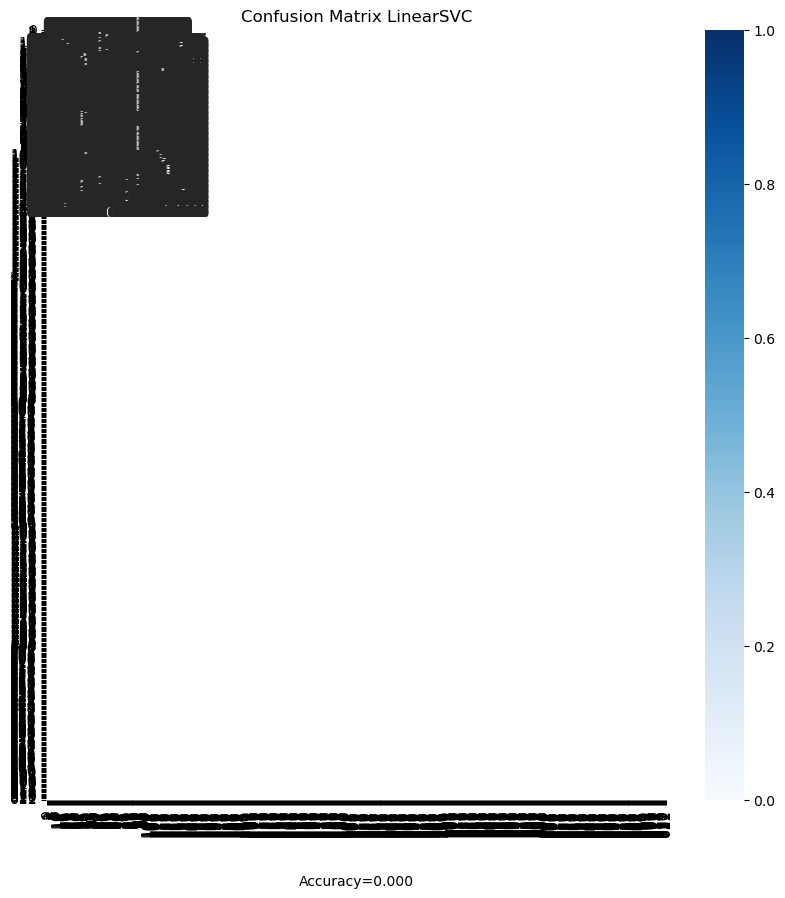

In [135]:
model = LinearSVC(C=1)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nThe confusion matrix is:")
print(cnf_matrix)

categories = y.unique()
make_confusion_matrix(cnf_matrix,
                      #group_names = labels,
                    categories=categories,
                     title = "Confusion Matrix LinearSVC",
                     xyplotlabels=False)


In [152]:
label_encoders = {}

le = LabelEncoder()

df['Encoded_Item'] = le.fit_transform(df['Item'])
original_items = le.classes_

le1 = LabelEncoder()
df['Encoded_Year'] = le.fit_transform(df['Year'])
label_encoders["Encoded_Year"] = le1

#print(df)

df3 = df.copy()
labels = df3["Encoded_Item"]

df3 = df3.drop(columns = ["Item", "Year", "Combined_Labels", "Encoded_Labels", 
                          "Production (t)", "Encoded_Item", "Encoded_Year"])
df3 = df3.dropna()
#print(df3)

df4 = pd.DataFrame()
df4["Item"] = df["Item"]
df4["Encoded_Item"]= df["Encoded_Item"]
df4['Decoded_Item'] = encoder.inverse_transform(df['Encoded_Item'])

df4

original_items


array(['Barley', 'Beans, dry', 'Maize (corn)', 'Oats', 'Potatoes', 'Rice',
       'Rye', 'Sorghum', 'Soya beans', 'Sugar cane', 'Wheat'],
      dtype=object)

Accuracy: 0.26

The confusion matrix is:
[[ 0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  3  0 14  0  0  0]
 [ 0  0  8  0  0  1  0  0  3  0  0]
 [ 0  0  0  0  0  0 16  1  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  7  2  0  0  0]
 [ 0  0  3  0  0  0  3  0  4  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  6  0  6  0  0  1]]


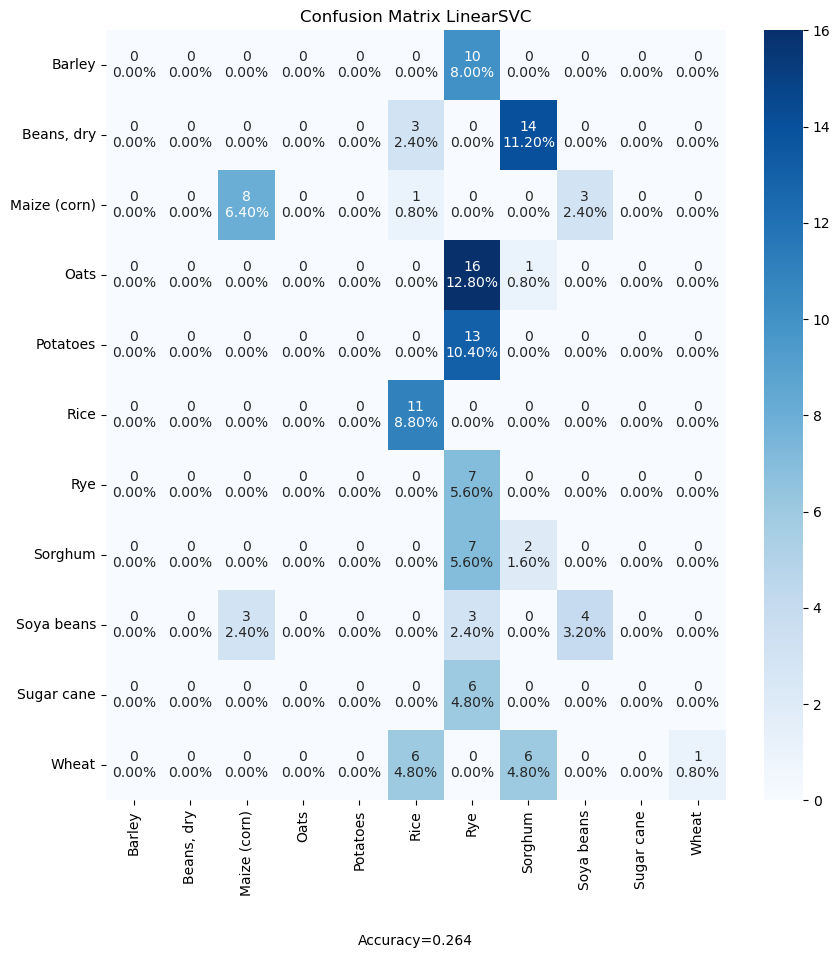

In [153]:
scaler = MinMaxScaler()


scaled_data = scaler.fit_transform(df3)


scaled_df = pd.DataFrame(scaled_data, columns=df3.columns)
#print(scaled_df)

X = scaled_df.copy()
y = labels.copy()
# Example of a binary target variable (e.g., 1 if 'Wheat', 0 otherwise)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(X_train)
#print(y_train)

model = LinearSVC(C=8)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nThe confusion matrix is:")
print(cnf_matrix)


categories = ['Barley', 'Beans, dry', 'Maize (corn)', 'Oats', 'Potatoes', 'Rice',
       'Rye', 'Sorghum', 'Soya beans', 'Sugar cane', 'Wheat']
make_confusion_matrix(cnf_matrix,
                      #group_names = labels,
                    categories=categories,
                     title = "Confusion Matrix LinearSVC",
                     xyplotlabels=False)



In [82]:
y_train

211     3
314     5
519     8
468     7
633    10
       ..
73      1
108     1
272     4
441     7
104     1
Name: Encoded_Item, Length: 498, dtype: int64

In [83]:
df3

,Crop Residues (N20),Export Quantity (t)
0,0.0083,0.00
1,0.0086,0.00
2,0.0074,0.00
3,0.0091,0.00
4,0.0091,0.00
...,...,...
677,1.3895,221248.64
678,1.4187,563643.06
679,1.6131,560878.50
680,1.9834,1129348.65


       Item  Year  Crop Residues (N20)  Production (t)  Export Quantity (t)  \
0    Barley  1961               0.0083         24310.0                 0.00   
1    Barley  1962               0.0086         27637.0                 0.00   
2    Barley  1963               0.0074         20484.0                 0.00   
3    Barley  1964               0.0091         28668.0                 0.00   
4    Barley  1965               0.0091         27451.0                 0.00   
..      ...   ...                  ...             ...                  ...   
677   Wheat  2018               1.3895       5469236.0            221248.64   
678   Wheat  2019               1.4187       5590815.0            563643.06   
679   Wheat  2020               1.6131       6344079.0            560878.50   
680   Wheat  2021               1.9834       7878413.0           1129348.65   
681   Wheat  2022               2.5707      10343182.0           3072779.16   

    Combined_Labels  Encoded_Labels  Encoded_Item  

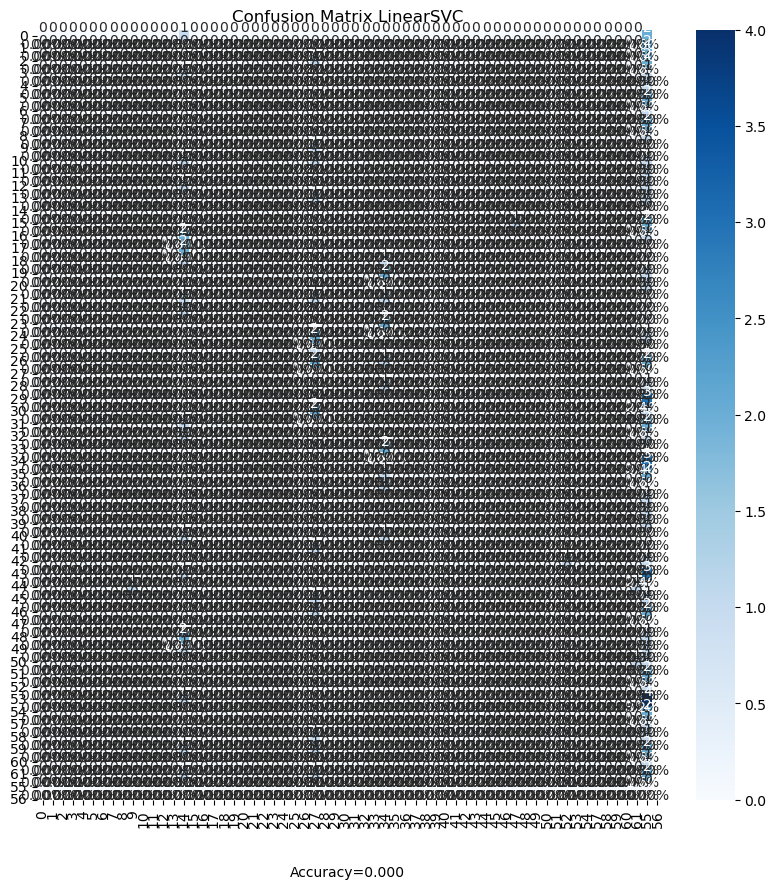

In [111]:

encoder = LabelEncoder()


df['Encoded_Item'] = encoder.fit_transform(df['Item'])
df['Encoded_Year'] = encoder.fit_transform(df['Year'])

print(df)

df3 = df.copy()
labels = df3["Encoded_Year"]

df3 = df3.drop(columns = ["Item", "Year", "Combined_Labels", "Encoded_Labels", 
                          "Production (t)", "Encoded_Item", "Encoded_Year"])
df3 = df3.dropna()
#print(df3)

scaler = MinMaxScaler()


scaled_data = scaler.fit_transform(df3)


scaled_df = pd.DataFrame(scaled_data, columns=df3.columns)
#print(scaled_df)

X = scaled_df.copy()
y = labels.copy()
# Example of a binary target variable (e.g., 1 if 'Wheat', 0 otherwise)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(X_train)
#print(y_train)

model = LinearSVC(C=10)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy:.2f}")

cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nThe confusion matrix is:")
print(cnf_matrix)

categories = y.unique()

make_confusion_matrix(cnf_matrix,
                      #group_names = labels,
                    categories=categories,
                     title = "Confusion Matrix LinearSVC",
                     xyplotlabels=False)

In [155]:
label_matrix = pd.DataFrame()
label_matrix["Encoded"] = [0,1,2,3,4,5,6,7,8,9,10]
label_matrix["Original"] = ['Barley', 'Beans, dry', 'Maize (corn)', 'Oats', 'Potatoes', 'Rice',
       'Rye', 'Sorghum', 'Soya beans', 'Sugar cane', 'Wheat']

label_matrix

,Encoded,Original
0,0,Barley
1,1,"Beans, dry"
2,2,Maize (corn)
3,3,Oats
4,4,Potatoes
5,5,Rice
6,6,Rye
7,7,Sorghum
8,8,Soya beans
9,9,Sugar cane


In [86]:
scaled_df1

,Crop Residues (N20),Export Quantity (t)
0,0.000264,0.000000
1,0.000274,0.000000
2,0.000235,0.000000
3,0.000289,0.000000
4,0.000289,0.000000
...,...,...
618,0.044193,0.002569
619,0.045122,0.006546
620,0.051305,0.006514
621,0.063083,0.013115


In [87]:
scaled_df2

,Crop Residues (N20),Production (t),Export Quantity (t)
0,0.000264,0.000032,0.000000
1,0.000274,0.000036,0.000000
2,0.000235,0.000027,0.000000
3,0.000289,0.000037,0.000000
4,0.000289,0.000036,0.000000
...,...,...,...
618,0.044193,0.007116,0.002569
619,0.045122,0.007274,0.006546
620,0.051305,0.008254,0.006514
621,0.063083,0.010250,0.013115


Accuracy: 0.39

The confusion matrix is:
[[ 0  0  0  0  0  0  0 10  0  0  0]
 [ 0  5  0  0  0  0  0  5  0  0  7]
 [ 0  0  6  0  0  5  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  2  0  0  0  0  3  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  0]
 [ 0  2  0  0  0  0  0  4  0  0  7]]


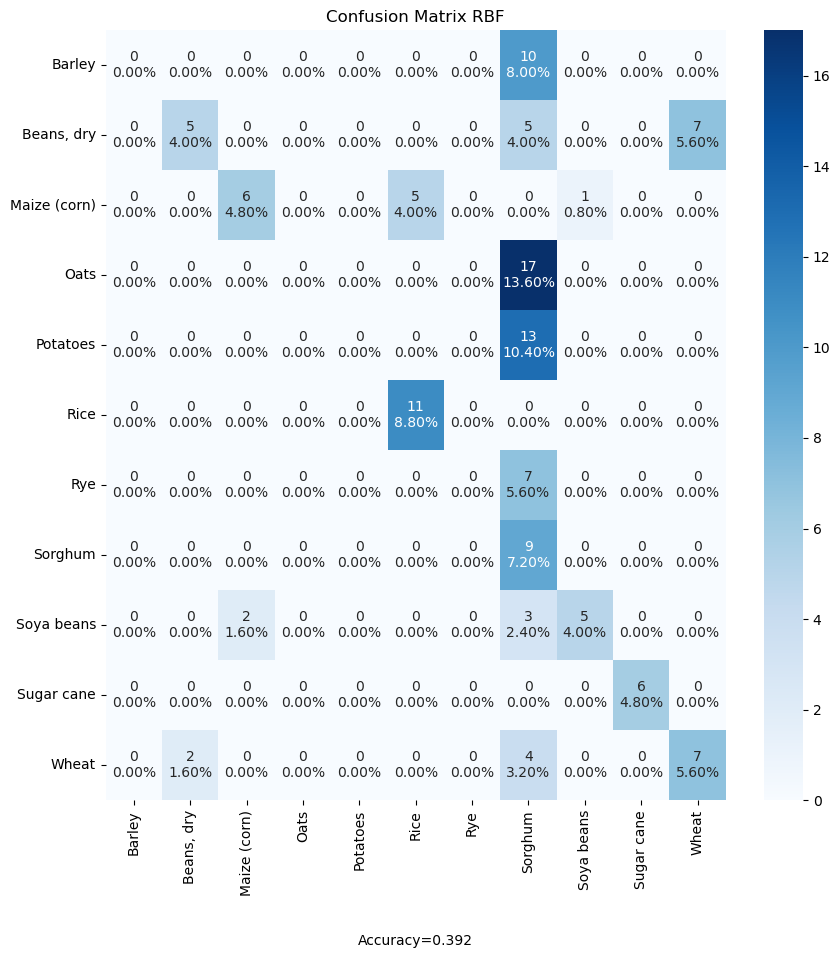

In [156]:
#Try with poly
X = scaled_df2.copy()
y = df["Encoded_Item"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train an SVM with Polynomial kernel (degree=2)
model = SVC(kernel='poly', degree=2, coef0=1)
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nThe confusion matrix is:")
print(cnf_matrix)

categories = label_matrix["Original"]

make_confusion_matrix(cnf_matrix,
                      #group_names = labels,
                    categories=categories,
                     title = "Confusion Matrix RBF",
                     xyplotlabels=False)

Accuracy: 0.78

The confusion matrix is:
[[ 6  0  0  2  0  0  2  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  1]
 [ 0  0 12  0  0  0  0  0  0  0  0]
 [ 8  0  0  6  0  0  1  2  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0]
 [ 0  0  1  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0]
 [ 1  0  0  2  0  0  3  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  0]
 [ 0  5  0  0  0  0  0  0  0  0  8]]


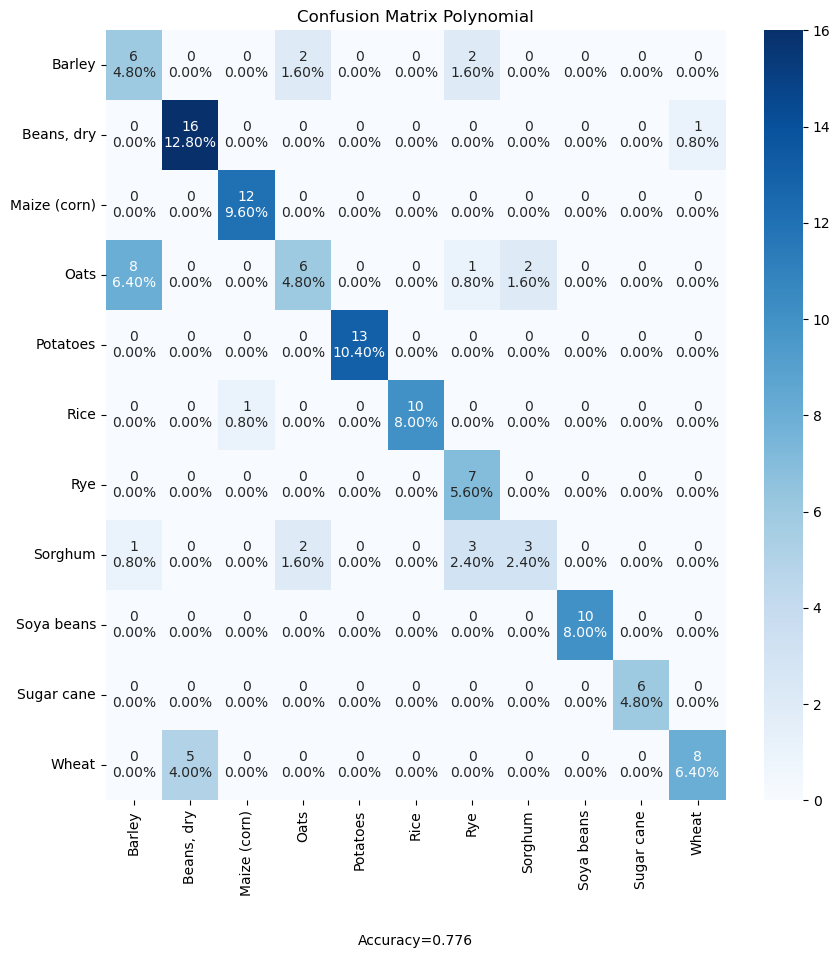

In [157]:
#Try with polynomial
X = scaled_df2.copy()
y = df["Encoded_Item"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train an SVM with Polynomial kernel (degree=2)
model = SVC(kernel='poly', degree=5, coef0=20)
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nThe confusion matrix is:")
print(cnf_matrix)

categories = label_matrix["Original"]

make_confusion_matrix(cnf_matrix,
                      #group_names = labels,
                    categories=categories,
                     title = "Confusion Matrix Polynomial",
                     xyplotlabels=False)


In [60]:
X_train

,Crop Residues (N20),Production (t),Export Quantity (t)
209,0.001221,0.000170,0.000000e+00
312,0.089955,0.009862,4.087805e-06
513,0.150840,0.020220,1.812930e-02
462,0.002160,0.000360,3.483925e-07
574,0.026370,0.003719,0.000000e+00
...,...,...,...
71,0.026491,0.003482,9.871120e-07
106,0.027203,0.004124,3.582287e-04
270,0.003222,0.002533,2.322616e-08
435,0.000013,0.000003,0.000000e+00


In [61]:
y_train

211     3
314     5
519     8
468     7
633    10
       ..
73      1
108     1
272     4
441     7
104     1
Name: Encoded_Item, Length: 498, dtype: int64

In [62]:
y_test.value_counts()

1     17
3     17
4     13
10    13
2     12
5     11
0     10
8     10
7      9
6      7
9      6
Name: Encoded_Item, dtype: int64

In [63]:

model = SVC(kernel='rbf')

# Define the parameter grid to search over
param_grid = {
    'C': [ 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, "scale", "auto"]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the model with the best hyperparameters
best_model = grid_search.best_estimator_
print(f"Best model accuracy: {best_model.score(X_test, y_test):.2f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found:  {'C': 1000, 'gamma': 'scale'}
Best model accuracy: 0.70


Accuracy: 0.70

The confusion matrix is:
[[ 7  0  0  0  0  0  3  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  1  0  0  0  0  0]
 [ 8  0  0  3  0  0  5  1  0  0  0]
 [ 2  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  1  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0]
 [ 3  0  0  1  0  0  3  2  0  0  0]
 [ 1  0  0  0  0  0  0  2  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  0]
 [ 0  6  0  0  0  0  0  1  0  0  6]]


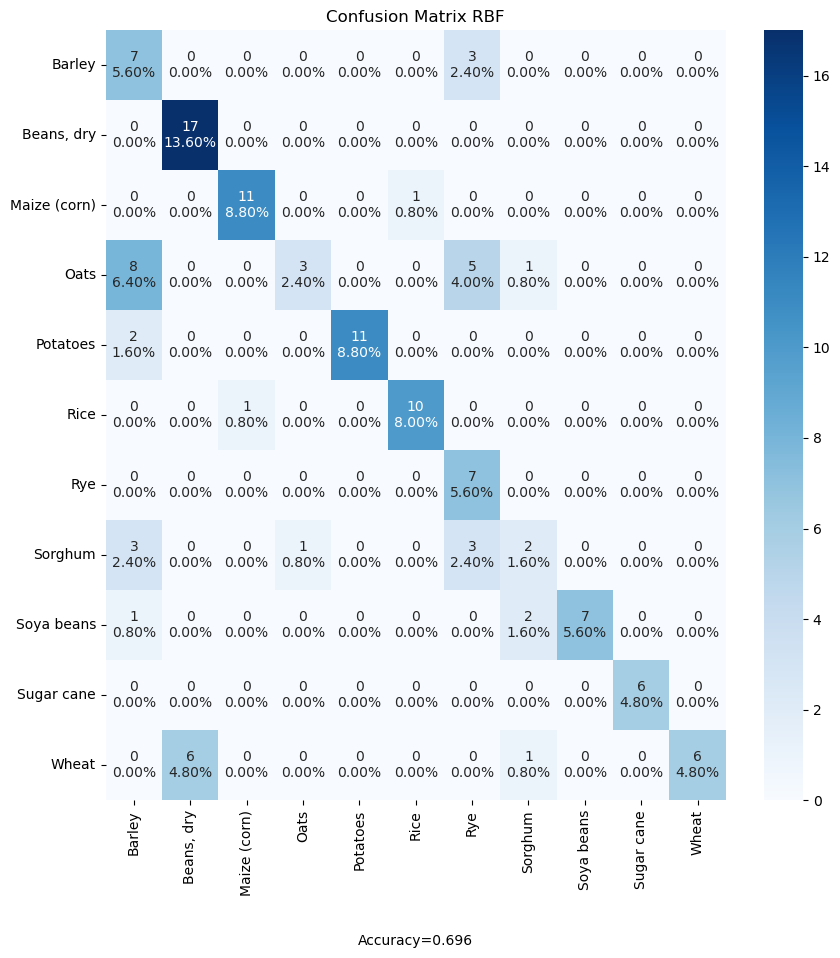

In [158]:
#Try with rbf
X = scaled_df2.copy()
y = df["Encoded_Item"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train an SVM with Polynomial kernel (degree=2)
model = SVC(kernel='rbf', C = 1000, gamma = "scale")
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nThe confusion matrix is:")
print(cnf_matrix)

categories = label_matrix["Original"]

make_confusion_matrix(cnf_matrix,
                      #group_names = labels,
                    categories=categories,
                     title = "Confusion Matrix RBF",
                     xyplotlabels=False)

In [65]:
#--------------other kernels
## RBF
SVM_Model2=sklearn.svm.SVC(C=10, kernel='rbf', 
                           verbose=True, gamma="auto")
SVM_Model2.fit(TRAIN, TRAIN_Labels)

print("SVM prediction:\n", SVM_Model2.predict(TEST))
print("Actual:")
print(TEST_Labels)

SVM_matrix = confusion_matrix(TEST_Labels, SVM_Model2.predict(TEST))
print("\nThe confusion matrix for rbf SVM is:")
print(SVM_matrix)
print("\n\n")

## POLY
SVM_Model3=sklearn.svm.SVC(C=10, kernel='poly',degree=3,
                           gamma="auto", verbose=True)

print(SVM_Model3)
SVM_Model3.fit(TRAIN, TRAIN_Labels)
print("SVM prediction:\n", SVM_Model3.predict(TEST))
print("Actual:")
print(TEST_Labels)

SVM_matrix = confusion_matrix(TEST_Labels, SVM_Model3.predict(TEST))
print("\nThe confusion matrix for SVM poly d=2  is:")
print(SVM_matrix)
print("\n\n")

###################################################
##
##   Visualizing the top features
##   Then Visualizing the margin with the top 2 in 2D
##
##########################################################

import matplotlib.pyplot as plt
## Credit: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
## Define a function to visualize the TOP words (variables)
def plot_coefficients(MODEL=SVM_Model, COLNAMES=TrainDF1.columns, top_features=10):
    ## Model if SVM MUST be SVC, RE: SVM_Model=LinearSVC(C=10)
    coef = MODEL.coef_.ravel()
    top_positive_coefficients = np.argsort(coef,axis=0)[-top_features:]
    top_negative_coefficients = np.argsort(coef,axis=0)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(  x=  np.arange(2 * top_features)  , height=coef[top_coefficients], width=.5,  color=colors)
    feature_names = np.array(COLNAMES)
    plt.xticks(np.arange(0, (2*top_features)), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    

plot_coefficients()
plt.savefig('KeyWords.pdf')


#########################################################
##  Using the top 2 features from above
## Let's look at the margin of the SVM
##################################################################
from sklearn.svm import SVC
X = np.array([TRAIN["dog"], TRAIN["hike"]])
X = X.transpose()
print(X)
#The classes of the training data
y = TRAIN_Labels
print(y)
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y=lb.fit_transform(y)

y = np.array(y)
y = y.ravel()  ## to make it the right 1D array type

print(y)


## Here - we need to make y into 0 or 1 so it will plot

#TRAIN
#Define the model with SVC
# Fit SVM with training data
clf = SVC(C=1, kernel="linear")
clf.fit(X, y) 


margin = 2 / np.sqrt(np.sum(clf.coef_ ** 2))

# get the separating hyperplane
#The weights vector w
w = clf.coef_[0]
#print("The weight vector ", w)

#The slope of the SVM sep line
a = -w[0] / w[1]
#print("The slope of the SVM sep line is ", a)

#Create a variable xx that are values between 4 and 8
xx = np.linspace(0, 10)

#Equation of sep line in 2D
# x1  = - b/w1  - (w0/w1 )(x0)
## Note that clf_intercept_[0] is "b"
## Note that a  = -w0/w1 and xx are a bunch of x values
## This is the y values for the main sep line
yy = a * xx - (clf.intercept_[0]) / w[1]

##These plot the two parellel margin lines
# plot the parallel lines to the separating hyperplane 
#that pass through the support vectors and note the margin
#margin = 2 / np.sqrt(np.sum(clf.coef_ ** 2))
#translate the location of the center sep line by
# adding or subtracting a fraaction of the margin 
yy_down = yy + .5*margin
yy_up = yy - .5*margin

# plot the line, the points, and the nearest vectors to the plane
#plt.figure(fignum, figsize=(4, 3))
plt.clf()
plt.plot(xx, yy, 'r-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=10,
                facecolors='none', zorder=5)
#cmap is the color map
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=5, cmap=plt.cm.Paired)

plt.axis('tight')





NameError: name 'sklearn' is not defined

In [ ]:
########################################

## IMPORTANT - YOU CANNOT LEAVE LABELS ON THE TEST SET
## Save labels
StudentTestLabels=StudentTestDF["Decision"]
#print(StudentTestLabels)
## remove labels
StudentTestDF = StudentTestDF.drop(["Decision"], axis=1)
#print(StudentTestDF)

## Set up the training data so the models get what they expect
StudentTrainDF_nolabels=StudentTrainDF.drop(["Decision"], axis=1)
#print(StudentTrainDF_nolabels)
StudentTrainLabels=StudentTrainDF["Decision"]
#print(StudentTrainLabels)

#------------------------
## Some models do not run on qualitative data.....
## So, we will need to remove the variables: Gender and State

StudentTrainDF_nolabels_quant=StudentTrainDF_nolabels.drop(["Gender"], axis=1)
StudentTrainDF_nolabels_quant=StudentTrainDF_nolabels_quant.drop(["State"], axis=1)
StudentTestDF_quant=StudentTestDF.drop(["Gender"], axis=1)
StudentTestDF_quant=StudentTestDF_quant.drop(["State"], axis=1)
#------------------------------





In [ ]:
#############################################
###########  SVM ############################
#############################################
#from sklearn.svm import LinearSVC
### NOTE - We CANNOT use SVM directly on the data. 
### SVMs do not run on qualitative data.

SVM_Model1=LinearSVC(C=50)
SVM_Model1.fit(StudentTrainDF_nolabels_quant, StudentTrainLabels)

print("SVM 1 prediction:\n", SVM_Model1.predict(StudentTestDF_quant))
print("Actual:")
print(StudentTestLabels)

SVM_matrix = confusion_matrix(StudentTestLabels, SVM_Model1.predict(StudentTestDF_quant))
print("\nThe confusion matrix for Linear SVM is:")
print(SVM_matrix)
print("\n\n")
#--------------other kernels
## RBF
SVM_Model2=sklearn.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma="auto")
SVM_Model2.fit(StudentTrainDF_nolabels_quant, StudentTrainLabels)

print("SVM prediction:\n", SVM_Model2.predict(StudentTestDF_quant))
print("Actual:")
print(StudentTestLabels)

SVM_matrix = confusion_matrix(StudentTestLabels, SVM_Model2.predict(StudentTestDF_quant))
print("\nThe confusion matrix for rbf SVM is:")
print(SVM_matrix)
print("\n\n")

## POLY
SVM_Model3=sklearn.svm.SVC(C=1.0, kernel='poly', degree=3, gamma="auto")
SVM_Model3.fit(StudentTrainDF_nolabels_quant, StudentTrainLabels)

print("SVM prediction:\n", SVM_Model3.predict(StudentTestDF_quant))
print("Actual:")
print(StudentTestLabels)

SVM_matrix = confusion_matrix(StudentTestLabels, SVM_Model3.predict(StudentTestDF_quant))
print("\nThe confusion matrix for poly p = 3 SVM is:")
print(SVM_matrix)
print("\n\n")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the polynomial kernel transformation function
def polynomial_kernel_transform(x, r=1, d=2):
    return np.array([x[0]**2, np.sqrt(2) * x[0] * x[1], x[1]**2])

# Define the 2D points
x1 = np.array([2, 3])  # Point 1
x2 = np.array([1, 4])  # Point 2

# Apply the polynomial kernel transformation
phi_x1 = polynomial_kernel_transform(x1)
phi_x2 = polynomial_kernel_transform(x2)

# Print the transformed points in higher-dimensional space
print("Original 2D Point 1:", x1)
print("Transformed 3D Point 1:", phi_x1)
print("Original 2D Point 2:", x2)
print("Transformed 3D Point 2:", phi_x2)

# Plotting the original and transformed points
fig = plt.figure(figsize=(12, 6))

# 1st subplot: Original 2D points
ax1 = fig.add_subplot(121)
ax1.scatter(x1[0], x1[1], color='r', label="Point 1 (2, 3)")
ax1.scatter(x2[0], x2[1], color='b', label="Point 2 (1, 4)")
ax1.set_title("Original 2D Points")
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
ax1.legend()

# 2nd subplot: Transformed 3D points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(phi_x1[0], phi_x1[1], phi_x1[2], color='r', label="Transformed Point 1")
ax2.scatter(phi_x2[0], phi_x2[1], phi_x2[2], color='b', label="Transformed Point 2")
ax2.set_title("Transformed 3D Points")
ax2.set_xlabel("X1^2")
ax2.set_ylabel("sqrt(2) * X1 * X2")
ax2.set_zlabel("X2^2")
ax2.legend()

plt.tight_layout()
plt.show()